In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from scipy.io import loadmat
from skimage import filters, morphology, exposure
from scipy.ndimage import binary_fill_holes
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt




In [2]:
# Load the saved model
model = load_model('BrainTumorClassfier2.h5' , compile=False)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

In [3]:
def find_image_in_hdf5(group):
    """
    Recursively explore HDF5 groups to identify and return the first dataset likely to be an image.
    This is done to make the model more flexibile to any .MAT file , and not hard coded to find a key named "Cjdata"    
    """
    best_candidate = None
    for key in group:
        item = group[key]
        if isinstance(item, h5py.Dataset):
            data = np.array(item)
            print(f"Inspecting dataset '{key}' with shape {data.shape} and data type {data.dtype}")
            if data.ndim >= 2 and data.dtype.kind in {'u', 'i', 'f'}:
                if best_candidate is None or (data.size > best_candidate.size and not np.isclose(data.max(), data.min())):
                    best_candidate = data
        elif isinstance(item, h5py.Group):
            result = find_image_in_hdf5(item)
            if result is not None:
                best_candidate = result if best_candidate is None or result.size > best_candidate.size else best_candidate
    return best_candidate




def skull_strip(image, fill_value=0):
    thresh = filters.threshold_otsu(image)
    binary = image > thresh
    binary = morphology.remove_small_objects(binary, min_size=64)
    binary = morphology.binary_closing(binary, morphology.disk(3))
    binary = binary_fill_holes(binary)
    return np.where(binary, image, fill_value)

def noise_reduction(image, kernel_size=3):
    if image.dtype == np.float64:
        image = np.uint8(image * 255)
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return blurred.astype(np.float64) / 255.0

def contrast_enhancement(image):
    p2, p98 = np.percentile(image, (2, 98))
    return exposure.rescale_intensity(image, in_range=(p2, p98))

def normalize_image(image):
    min_val, max_val = np.min(image), np.max(image)
    return (image - min_val) / (max_val - min_val)

def preprocess_image(file_path):
    """
    Open a file and preprocess the image for analysis.
    It can handle both .mat files (assuming they are in HDF5 format) and .png files.
    """
    if file_path.endswith('.mat'):
        with h5py.File(file_path, 'r') as file:
            image = find_image_in_hdf5(file)
            if image is None:
                raise ValueError("No suitable image dataset found in the HDF5 file.")
    elif file_path.endswith('.jpg'):
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError("Failed to load image from .png file.")
    else:
        raise ValueError("Unsupported file format. Only .mat and .png are supported.")

    # Preprocessing pipeline
    image = cv2.resize(image, (224, 224))
    image = skull_strip(image)
    image = noise_reduction(image)
    image = contrast_enhancement(image)
    image = normalize_image(image)
    return image.reshape((1, 224, 224, 1)).astype('float32')

def plot_single_image(image_data, title):
    image_data = np.squeeze(image_data)
    plt.figure(figsize=(6, 6))
    plt.imshow(image_data, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()



Inspecting dataset 'PID' with shape (6, 1) and data type uint16
Inspecting dataset 'image' with shape (512, 512) and data type int16
Inspecting dataset 'label' with shape (1, 1) and data type float64
Inspecting dataset 'tumorBorder' with shape (1, 110) and data type float64
Inspecting dataset 'tumorMask' with shape (512, 512) and data type uint8


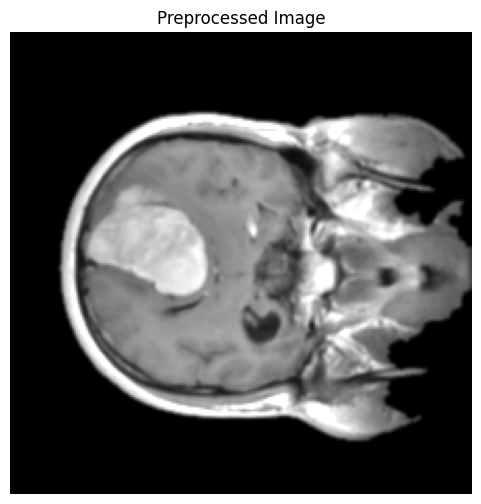

In [5]:
# Example usage on mat 
file_path = r"C:\Users\omarb\OneDrive\Desktop\Random Brain Images\302.mat"
preprocessed_image = preprocess_image(file_path)
plot_single_image(preprocessed_image, "Preprocessed Image")

In [6]:
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)[0]
class_probabilities = predictions[0]

# Print the results
classes = ['No Tumor', 'Meningioma', 'Glioma', 'Pituitary Tumor']
print(f"Predicted class: {classes[predicted_class]}")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {class_probabilities[i]:.4f}")

1/1 [==============================] - 0s 417ms/step
Predicted class: Meningioma
No Tumor: 0.0000
Meningioma: 0.9285
Glioma: 0.0715
Pituitary Tumor: 0.0000


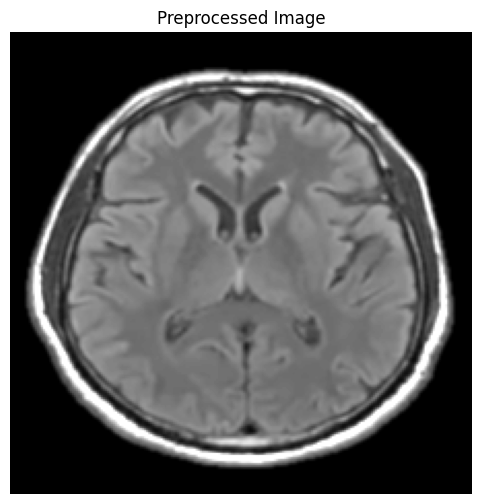

In [7]:
# Example usage on jpg
file_path = r"C:\Users\omarb\OneDrive\Desktop\Random Brain Images\Te-no_0102.jpg" # Change this path to point to a .mat or .png file
preprocessed_image = preprocess_image(file_path)
plot_single_image(preprocessed_image, "Preprocessed Image")


In [8]:
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)[0]
class_probabilities = predictions[0]

# Print the results
classes = ['No Tumor', 'Meningioma', 'Glioma', 'Pituitary Tumor']
print(f"Predicted class: {classes[predicted_class]}")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {class_probabilities[i]:.4f}")

1/1 [==============================] - 0s 105ms/step
Predicted class: No Tumor
No Tumor: 1.0000
Meningioma: 0.0000
Glioma: 0.0000
Pituitary Tumor: 0.0000


Inspecting dataset 'PID' with shape (6, 1) and data type uint16
Inspecting dataset 'image' with shape (512, 512) and data type int16
Inspecting dataset 'label' with shape (1, 1) and data type float64
Inspecting dataset 'tumorBorder' with shape (1, 28) and data type float64
Inspecting dataset 'tumorMask' with shape (512, 512) and data type uint8


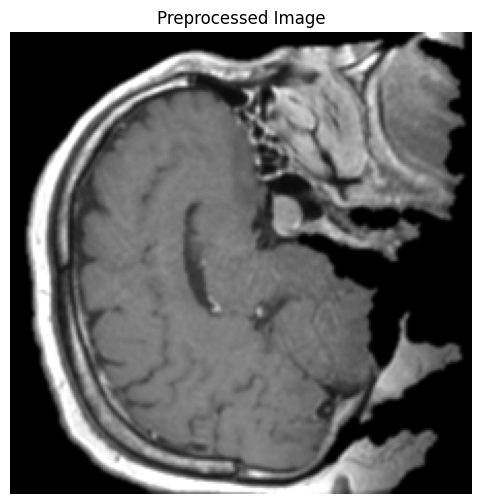

In [9]:
# Example usage on jpg
file_path = r"C:\Users\omarb\OneDrive\Desktop\Random Brain Images\1167.mat" # Change this path to point to a .mat or .png file
preprocessed_image = preprocess_image(file_path)
plot_single_image(preprocessed_image, "Preprocessed Image")


In [10]:
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)[0]
class_probabilities = predictions[0]

# Print the results
classes = ['No Tumor', 'Meningioma', 'Glioma', 'Pituitary Tumor']
print(f"Predicted class: {classes[predicted_class]}")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {class_probabilities[i]:.4f}")

1/1 [==============================] - 0s 102ms/step
Predicted class: Pituitary Tumor
No Tumor: 0.0000
Meningioma: 0.0000
Glioma: 0.0000
Pituitary Tumor: 1.0000
